# Simulating a simple pendulum

In [ ]:
#| default_exp simple_pendulum

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from collections import defaultdict
from time import time as systime

In [ ]:
#| include: false
from IPython.display import Image
from IPython.display import HTML
#import time as systime

# To support animations
from matplotlib import animation, rc

In [ ]:
#| hide
# This is equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [ ]:
#| include: false
# %matplotlib notebook

## Modelling a simple pendulum

<table style='margin: 0 auto' rules=none>
    <tr>
    <td> <img src="../img/n8-1-pendulum.png" alt="n8-1-pendulum" style="height: 300px;"/> </td>        
    </tr>
</table>

We first draw the free-body diagram where the forces acting on the pendulum are its weight and the reaction at the rotational joint. We also include a moment due to the friction in the joint (and the rotary potentiometer). The simplest approach to modeling assumes the mass of the bar is negligible and that the entire mass of the pendulum is concentrated at the center of the end weight.

<table style='margin: 0 auto' rules=none>
    <tr>
    <td> <img src="../img/n8-2-pendFBD.png" alt="n8-2-pendFBD" style="height: 300px;"/> </td>        
    </tr>
</table>

- The equation of motion of the pendulum can then be derived by summing the moments. 
- We will choose to sum the moments about the attachment point $O$ since that point is the point being rotated about and since the reaction force does not impart a moment about that point.

We can then write:

$$ \sum{M} = (M+m)glsin(\theta) - T_{fric} = I_O\ddot\theta$$

Assuming that the mass of the pendulum is concentrated at its end mass, the mass moment of inertia is $I_O \approx (M+m)l^2$. A more accurate approach would be to consider the rod and end mass explicitly. In that case, the weight of the system could be considered to be located at the system's mass center $l_G = (Ml+0.5ml))/(M+m)$. In that case, the mass moment of inertia is $I_O = ml^2/3 + Ml^2$. Depending on the parameters of your particular pendulum, you can assess if this added fidelity is necessary.

We will also initially assume a viscous model of friction, that is, $T_{Fric} = -b\dot{\theta}$ where $b$ is a constant. Such a model is nice because it is linear. We will assess the appropriateness of this model later. Sometimes the frictional moment is not linearly proportional to the angular velocity. Sometimes, the stiction in the joint is significant enough that it must be modeled too.

Taking into account the above assumptions, our equation of motion becomes the following.

$$ -(M+m)gl_G\sin\theta - b\dot{\theta} = I_O\ddot{\theta} $$

### Parameters

We will use the same parameters of this [pendulum](https://ctms.engin.umich.edu/CTMS/index.php?aux=Activities_Pendulum). 

This is a simple pendulum that consists of:
- a rod of length $l = 0.43\ \mbox{m}$ and mass $m = 0.095\ \mbox{kg}$ 
- an end mass of $0.380\ \mbox{kg}$. 

Assuming that the mass of the pendulum is concentrated at its end mass, the mass moment of inertia is $I_O \approx (M+m)l^2$. A more accurate approach would be to consider the rod and end mass explicitly. In that case, the weight of the system could be considered to be located at the system's mass center $l_G = (Ml+0.5ml))/(M+m)$. In that case, the mass moment of inertia is $I_O = ml^2/3 + Ml^2$. Depending on the parameters of your particular pendulum, you can assess if this added fidelity is necessary.

Therefore, the difference between $l = 0.43\ \mbox{m}$ and $l_G = 0.39\ \mbox{m}$ is significant enough to include. 

The difference between $I_O \approx (M+m)l^2 = 0.088\ \mbox{kg-m}^2$ and $I_O = ml^2/3 + Ml^2 = 0.076\ \mbox{kg-m}^2$ is also significant enough to include.

### Experimental parameters

After model identification the following parameters are identified:

$$ I_O = 0.079\ \mbox{kg-m}^2 $$
$$ b = 0.003\ \mbox{N-m-s}^2 $$

Recalling the model we derived from first principles earlier.

$$ I_O\ddot{\theta} + b\dot{\theta} + (M+m)gl_G\sin\theta = 0 $$

The final equation is:

$$
0.079\ddot{\theta} + 0.003\dot{\theta} + 1.82\sin\theta = 0 
$$


We can write this as:

$$\dot{x_1}= x_2$$
$$\dot{x_2}=\frac{1}{0.079}\big ( -1.82\sin x_1 -0.003 x_2  \big)$$


In [ ]:
#| export
class PendulumParameters:
    _g = 9.81          # acceleration due to gravity (m/s^2)

    def __init__(self, 
                 rod_length=0.43, # m
                 rod_mass=0.095,  # kg
                 bob_mass=0.380,  # kg
                 b=0.003):        # estimate of viscous friction coefficient (N-m-s)
        self._rod_length = rod_length # m
        self._rod_mass = rod_mass  # kg
        self._bob_mass = bob_mass  # kg
        self._b = b       
        self._update_params()
        
    def _update_params(self):
        self._I0 = self._rod_mass*self._rod_length**2/3 + self._bob_mass*self._rod_length**2 # estimate of pendulum mass moment of inertia (kg-m^2) - e.g. 0.079 
        self._l_G = (self._bob_mass*self._rod_length+0.5*self._rod_mass*self._rod_length)/(self._bob_mass+self._rod_mass);   # location of pendulum mass center (m)
    
    @property
    def b(self):
        return self._b
    
    @b.setter
    def b(self, v):
        self._b = v
        self._update_params()
    
    @property
    def rod_length(self):
        return self._rod_length
    
    @rod_length.setter
    def rod_length(self, l):
        self._rod_length = l
        self._update_params()

    @property
    def rod_mass(self):
        return self._rod_mass
    
    @rod_mass.setter
    def rod_mass(self, m):
        self._rod_mass = m
        self._update_params()
        
    @property
    def bob_mass(self):
        return self._bob_mass
    
    @rod_mass.setter
    def bob_mass(self, m):
        self._bob_mass = m
        self._update_params()

In [ ]:
#| export
class Load():
    def position(self):
        raise Exception("Not implemented.")
    def speed(self):
        raise Exception("Not implemented")
    def moment_of_inertia(self):
        raise Exception("Not implemented.")

In [ ]:
#| export
class Pendulum(Load):
    def __init__(self, theta_0, theta_dot_0, params):
        self._x_1 = theta_0     # theta (position - (rad))
        self._x_2 = theta_dot_0 # theta_dot (velocity - (rad/s))
        self._params = params
        self._time_elapsed = 0
        
    def step(self, dt, u=0):
        self._x_1 = self._x_1 + dt*self._x_2
        self._x_2 = self._x_2 + \
            dt*1/self._params._I0*(+u \
                                   -(self._params._bob_mass+self._params._rod_mass)*PendulumParameters._g*self._params._l_G*np.sin(self._x_1) \
                                   - self._params._b*self._x_2)
        self._time_elapsed += dt
        
    def rod_position_at(self, angle_deg):
        rod_end_1 = 0, 0
        rod_end_2 = rod_end_1[0]+ self._params._rod_length*np.sin(np.radians(angle_deg)), \
                    rod_end_1[1]- self._params._rod_length*np.cos(np.radians(angle_deg)), 
        return rod_end_1, rod_end_2
    
    def rod_position(self):
        return self.rod_position_at(self.sense_theta_deg())
    
    def position(self):    
        return self._x_1 # we measure theta (rad)
    
    def speed(self):
        return self._x_2 # we need this to connect to a motor
    
    def sense_theta_deg(self):
        return np.degrees(self._x_1) # we measure theta (deg)

    def moment_of_inertia(self):
        return self._params._I0

We now create our pendulum with specific initial conditions

In [ ]:
pendulum = Pendulum( theta_0 = 0.423, theta_dot_0 = 0, params=PendulumParameters())

And finally we define the simulation parameters and run the simulation

In [ ]:
t0, tf, dt = 0, 15, 0.01 # time

angle = []
time = np.arange(t0, tf, dt)
for t in time:
    pendulum.step(dt, u=0.0)
    angle.append(pendulum.sense_theta_deg())
    

Let's plot the results:

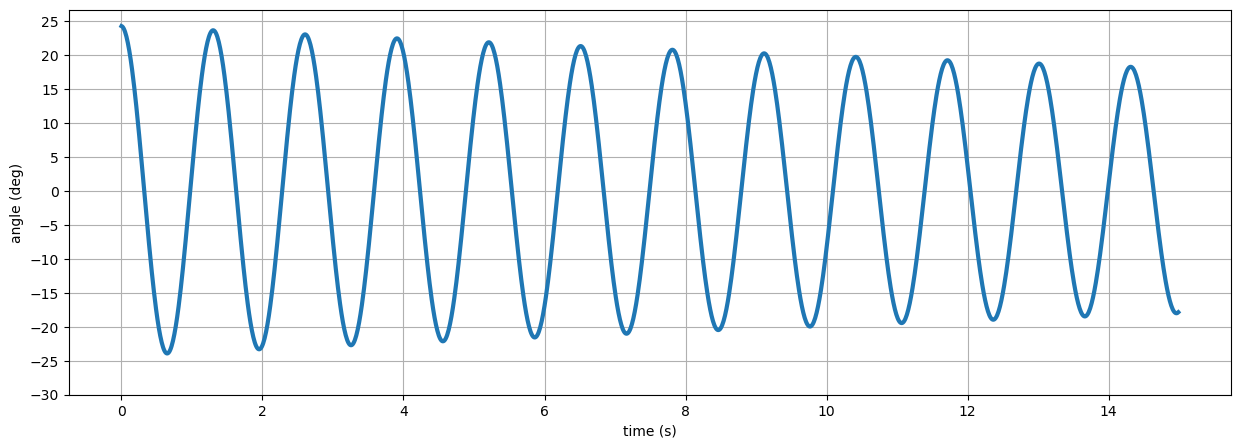

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(time, angle, linewidth=3)
plt.grid()
plt.yticks(np.arange(-30, 30, step=5))  # Set label locations.
plt.ylabel('angle (deg)')
plt.xlabel('time (s)');

As expected the pendulum oscillates, with decreasing amplitude which depends on the damping coefficient (try different values of the viscous friction coefficient $b$ in the class parameter to see how it affects the response).

We can also verify what happens when we apply an esternal torque $u$

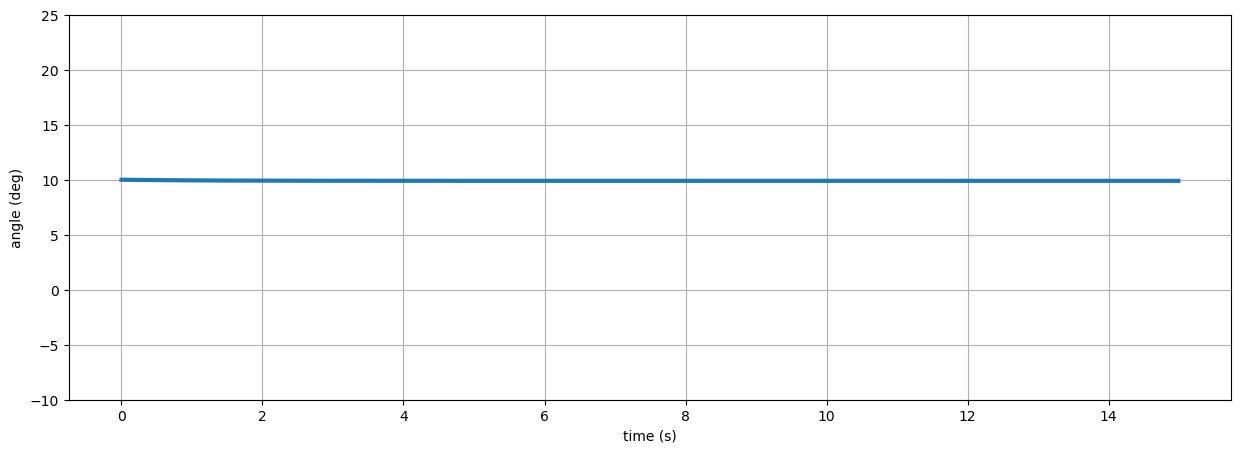

In [ ]:
params = PendulumParameters()
params.b = 2
pendulum = Pendulum( theta_0 = np.radians(10), theta_dot_0 = 0, params=params)
t0, tf, dt = 0, 15, 0.01 # time

angle = []
time = np.arange(t0, tf, dt)
for t in time:
    pendulum.step(dt, u=0.31)
    angle.append(pendulum.sense_theta_deg())
    
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(time, angle, linewidth=3)
plt.grid()
plt.yticks(np.arange(-10, 30, step=5))  # Set label locations.
plt.ylabel('angle (deg)')
plt.xlabel('time (s)');    

## Animating a pendulum

Let's now animate the pendulum so that we can get a better intuition of how it behaves.

The `PendulumDrawer` class does the animation manually, drawing each single frame explicitely. Using this method results in quite slow rendering performance. We will use the FuncAnimation to solve this issue. For now, let's see how the PendulumDrawer class could be defined.

In [ ]:
#| export
class PendulumDrawer():
    def __init__(self, pendulum):
        self._pendulum = pendulum
        self._rod_points = []
        self._bob_points = []
        
    def draw(self, ax):
        rod_end_1, rod_end_2 = self._pendulum.rod_position()
        
        assert abs(self._pendulum._params._rod_length - np.linalg.norm(rod_end_2)) < 0.01, "rod length is variable: , {} != {}".format(self._pendulum._params._rod_length, np.linalg.norm(rod_end_2))
        
        if type(pendulum_drawer._bob_points) != matplotlib.lines.Line2D: #len(self._bob_points) == 0:
            self._rod_points, = ax.plot([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]], linewidth=3, color='black')
            self._bob_points, = ax.plot(rod_end_2[0], rod_end_2[1], marker='.', markersize=40, color='red')
        else:
            self._rod_points.set_xdata([rod_end_1[0], rod_end_2[0]])
            self._rod_points.set_ydata([rod_end_1[1], rod_end_2[1]])
            self._bob_points.set_xdata(rod_end_2[0])
            self._bob_points.set_ydata(rod_end_2[1])
            
    
    def animated_draw(self, ax):
        rod_end_1, rod_end_2 = self._pendulum.rod_position()
        assert abs(self._pendulum._params._rod_length - np.linalg.norm(rod_end_2)) < 0.01, "rod length is variable: , {} != {}".format(self._pendulum._params._rod_length, np.linalg.norm(rod_end_2))
        
        if type(pendulum_drawer._bob_points) != matplotlib.lines.Line2D: #len(self._bob_points) == 0:            
            self._rod_points = ax.plot([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]], linewidth=3, color='black', animated=True)
            self._bob_points, = ax.plot(rod_end_2[0], rod_end_2[1], marker='.', markersize=40, color='red', animated=True)
        else:
            self._rod_points.set_xdata([rod_end_1[0], rod_end_2[0]])
            self._rod_points.set_ydata([rod_end_1[1], rod_end_2[1]])
            self._bob_points.set_xdata(rod_end_2[0])
            self._bob_points.set_ydata(rod_end_2[1])
        return [self._rod_points, self._bob_points]

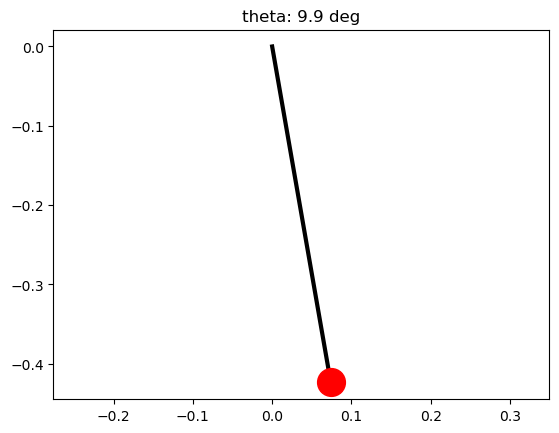

In [ ]:
pendulum_drawer = PendulumDrawer(pendulum)
fig, ax = plt.subplots(1,1)
pendulum_drawer.draw(ax)
plt.title('theta: {:.1f} deg'.format(pendulum_drawer._pendulum.sense_theta_deg()))
plt.axis('equal');

If we used the `PendulumDrawer` class our rendering will be very slow.
Let's now leverage matplotlib functionalities directly to have a better animation. This is done through the class `AnimatePendulum`.

In [ ]:
#| export
class AnimatePendulum():
    """See also: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/"""
    def __init__(self, pendulum, t0, tf, dt):
        self._pendulum = pendulum
        self._t0, self._tf, self._dt = t0, tf, dt
        self._data = defaultdict(list)
        
        self._fig = plt.figure()
        self._ax = self._fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                 xlim=(-.5, .5), ylim=(-.5, 0))
        self._ax.grid()
        self._line, = self._ax.plot([], [], 'o-', lw=2)   
        
        self._title = self._ax.text(0.5, 1.05, "", #bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                    transform=self._ax.transAxes, ha="center")
        
    def animate_init(self):
        """Initialize animation.
           Plot the background of each frame. """
        self._line.set_data([], [])        
        return self._line,
    
    def simulate(self, u):        
        for t in np.arange(start=t0, stop=tf, step=dt):
            self._pendulum.step(dt, u)
            self._data['angles'].append(self._pendulum.sense_theta_deg())
            self._data['time'].append(t)
    
    def animate(self, i):           
        """Animation function. 
           This is called sequentially to perform animation step"""                
        rod_end_1, rod_end_2 = self._pendulum.rod_position_at(self._data['angles'][i])
        self._line.set_data([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]])
        self._title.set_text(u"t = {:.1f}s".format(self._data['time'][i]))        
        return self._line, self._title
    
    def animate_and_simulate(self, i):   
        """Animation function. 
           This is called sequentially to perform animation step"""        
        self._pendulum.step(self.dt, u=0)     
        rod_end_1, rod_end_2 = self._pendulum.rod_position()
        self._line.set_data([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]])
        return line, time_text
    
    def start_animation(self):
        # choose the interval based on dt and the time to animate one step
        t_start = systime()
        self.animate(0)
        t_end = systime()
        interval = 1000 * self._dt - (t_end - t_start)
        n_frames = int((self._tf-self._t0)/self._dt)
        
        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(self._fig, self.animate, init_func=self.animate_init,
                                       frames=n_frames, interval=interval, blit=True,
                                       repeat_delay=10000, repeat=True);
        plt.close()
        return anim

And now we can put everything together and animate our pendulum!

In [ ]:
#%%capture
t0, tf, dt = 0, 10, 1./30 # time
ap = AnimatePendulum(Pendulum(theta_0=np.radians(10), theta_dot_0=0, params=PendulumParameters()), t0, tf, dt)
ap.simulate(u=0.31);
ap.start_animation()

---------------

## DC Motor

This part is based on equations presented [here](https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling) and [here](https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemAnalysis).

Additional explanation on the motor are presented [here](https://www.youtube.com/watch?v=leMleP_Q5gs)

More references are
- [DC Motor Transfer Function](http://edge.rit.edu/edge/P14453/public/Research/DC%20Motor%20Transfer%20Function%20Example.pdf)
- [Transfer functions of DC Motors](https://www.engr.siu.edu/staff/spezia/Web438A/Lecture%20Notes/lesson14et438a.pdf)

In [ ]:
class DCMotorParams():
    def __init__(self, J=0.01, b=0.1, K=0.01, R=1, L=0.5):
            #     (J)     moment of inertia of the rotor     0.01 kg.m^2
            #     (b)     motor viscous friction constant    0.1 N.m.s
            #     (Ke)    electromotive force constant       0.01 V/rad/sec
            #     (Kt)    motor torque constant              0.01 N.m/Amp
            #     (R)     electric resistance                1 Ohm
            #     (L)     electric inductance                0.5 H
            #      Note that in SI units, Ke = Kt = K
        self.J = J
        self.b = b
        self.K = K
        self.R = R
        self.L = L
                
class DCMotor():
    def __init__(self, x0, params):
        self._params  = params
                
        self._x0 = x0
        self._x = x0
        self._J_load = 0
        self.update_motor_matrix()
        
    def update_motor_matrix(self):
        # state variables are: rotation speed (w, or theta_dot) and current (i)
        self._A = np.array([[-self._params.b/(self._params.J+self._J_load),  self._params.K/(self._params.J+self._J_load)],
                            [-self._params.K/self._params.L,  -self._params.R/self._params.L]])
        self._B = np.array([[0],[1/self._params.L]])
        self._C = np.array([1,   0])
        self._D = 0;
        
    def reset(self):
        self._x = self._x0
        
    def set_load(self, J_load):
        self._params.J += J_load   
        self.update_motor_matrix()
        
    def step(self, dt, u):
        self._x = self._x + dt*(self._A@self._x + self._B*u)
              
    def measure_speed(self):
        self._y = self._C@self._x 
        return self._y

In [ ]:
motor = DCMotor(np.array([[0], [0]]), DCMotorParams())

In [ ]:
y = []
u = 1

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y.append(motor.measure_speed())  

Text(0, 0.5, 'speed (w, rad/s)')

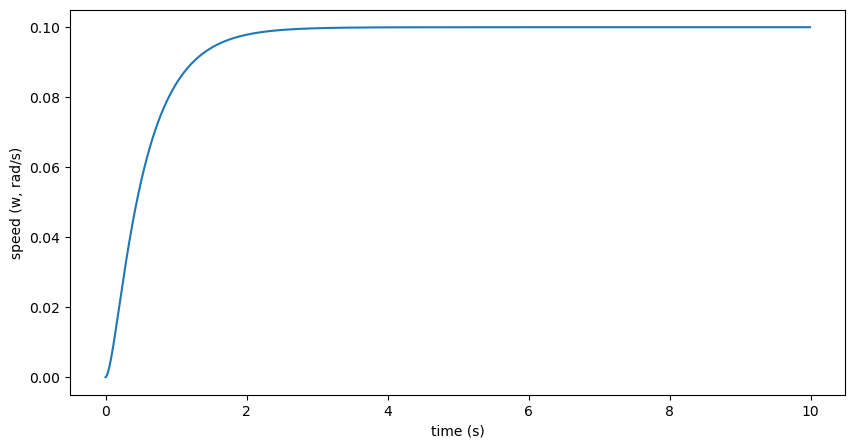

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.plot(time_vector, y)
plt.xlabel('time (s)')
plt.ylabel('speed (w, rad/s)')

In [ ]:
motor.reset()
motor.set_load(0.1)

In [ ]:
y = []
u = 1

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y.append(motor.measure_speed())    

Text(0, 0.5, 'speed (w, rad/s)')

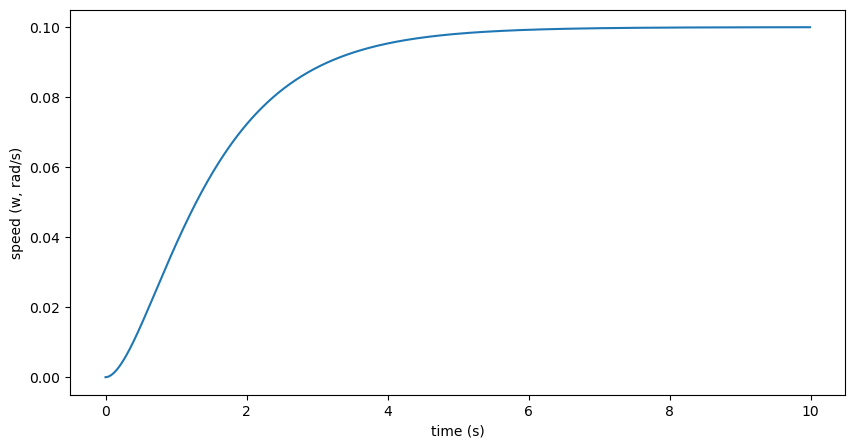

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.plot(time_vector, y)
plt.xlabel('time (s)')
plt.ylabel('speed (w, rad/s)')

### Extended DCMotor

We modify the usual definition of the motor (see above), adding one state to explicit the rotor position.

We also define a wrapping function to make sure the rotor position stays within -pi and pi.

In [ ]:
#| export
def wrap(angle):
    "Wraps an angle between -pi and pi."
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [ ]:
#| export
class DCMotorParams():
    def __init__(self, J=0.01, b=0.1, K=0.01, R=1, L=0.5):
            #     (J)     moment of inertia of the rotor     0.01 kg.m^2
            #     (b)     motor viscous friction constant    0.1 N.m.s
            #     (Ke)    electromotive force constant       0.01 V/rad/sec
            #     (Kt)    motor torque constant              0.01 N.m/Amp
            #     (R)     electric resistance                1 Ohm
            #     (L)     electric inductance                0.5 H
        self.J = J
        self.b = b
        self.K = K
        self.R = R
        self.L = L
        
class DCMotor():
    def __init__(self, x0, params):
        self._params  = params
                
        self._x0 = x0
        self._x = x0
        self._J_load = 0
        self._update_motor_matrix()
        
        self._load = False
        
    def _update_motor_matrix(self):
        # state variables are: position (theta), rotation speed (w, or theta_dot) and current (i)
        self._A = np.array([
            [0, 1, 0],
            [0, -self._params.b/(self._params.J+self._J_load),  self._params.K/(self._params.J+self._J_load)],
            [0, -self._params.K/self._params.L,  -self._params.R/self._params.L]
            ])
        self._B = np.array([[0],[0],[1/self._params.L]])
        self._C = np.array([
            [1, 0, 0], # position
            [0, 1, 0]  # velocity
        ])
        self._D = 0;
        
    def step(self, dt, u):
        self._x = self._x + dt*(self._A@self._x + self._B*u)
        
        # wrap theta to stay between -pi and pi
        self._x[0] = wrap(self._x[0])
    
    def reset(self):
        self._x = self._x0
        
    def set_load_parameters(self, J_load):
        self._params.J += J_load   
        self.update_motor_matrix()
        
    def connect_to(self, load):
        self._load = load
        self._params.J = load.moment_of_inertia()   
        self._update_motor_matrix()
            
    def _output_equation(self):
        return self._C@self._x         
    
    def measure(self):
        # We need to move this function out of the DCMotor class.        
        return np.array([[self._load.position()], [self._load.speed()]]) \
                        if self._load else self._output_equation()                

    
    
    def get_motor_torque(self):
        """the motor torque is proportional to only the armature current `i` by a constant factor `K`: T=K*i"""
        return self._params.K*self._x[1,0]

In [ ]:
motor = DCMotor(x0=np.array([[0], [0], [0]]), params=DCMotorParams())
y = np.array([[0],[0]]) # initialise to 0. This is only here to have the correct size. Alternative: y = np.empty((2,1)) 

u = 1

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y = np.append(y, motor.measure(), axis=1)   
    
# remove the first item which was there only to have the correct size
y = np.delete(y, 0, axis=1)

position = y[0,:]
velocity = y[1,:]

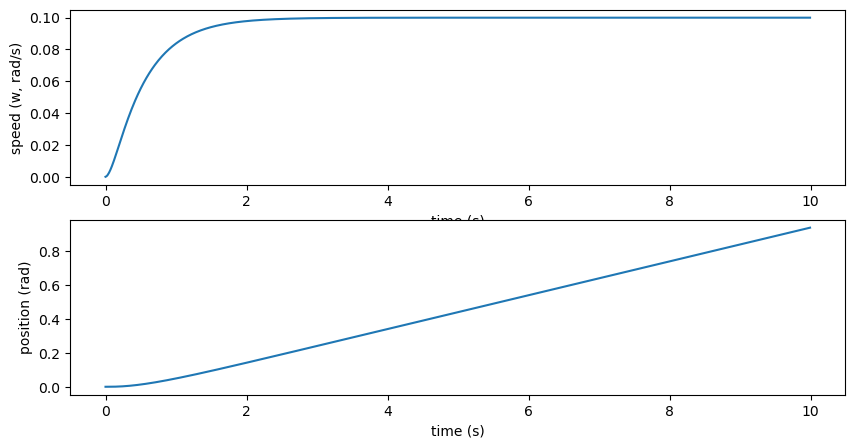

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,5))

axs[0].plot(time_vector, velocity)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('speed (w, rad/s)')

axs[1].plot(time_vector, position)
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('position (rad)');

Or if we want to express it as a transfer function:
$$ 
P(s) = \frac{\dot\Theta(s)}{V(s)} = \frac{K}{(Js+b)(Ls+R) + K^2}
$$

and if we want to measure the position

$$ 
\tilde{P}(s) = \frac{\Theta(s)}{V(s)} = \frac{K}{s(Js+b)(Ls+R) + K^2}
$$

## Adding a motor controller

We can now control the position of the motor

In [ ]:
motor = DCMotor(x0=np.array([[0], [0], [0]]), params=DCMotorParams())
Kp = 10
Kd = 3
Ki = .1

y_history = np.array([[0],[0]]) # initialise to 0. This is only here to have the correct size. Alternative: y = np.empty((2,1)) 
error_history = np.array([[0]])

ref_position = np.radians(1) # position reference
time_vector = np.arange(0, 10, 0.01)

error_old = 0
error_dot = 0
error_I  = 0
for t in time_vector:   
    y = motor.measure()
    position, velocity = y[0], y[1]
    error = ref_position - position
    error_dot = (error - error_old)/0.01
    error_I   += error*0.01
    error_old = error
    # controller
    u = Kp*error + Kd*error_dot + Ki*error_I
    motor.step(0.01, u)

    # save the last measurements
    y_history = np.append(y_history, y, axis=1)  
    error_history = np.append(error_history, [error], axis=1)


    
    
# remove the first item which was there only to have the correct size
y_history = np.delete(y_history, 0, axis=1)
error_history = np.delete(error_history, 0, axis=1)

position = y_history[0,:]
velocity = y_history[1,:]
error = error_history[0,:]

print('Reference (rad)/(deg): {:.5f}/{:.2f}'.format(np.radians(ref_position), ref_position))

Reference (rad)/(deg): 0.00030/0.02


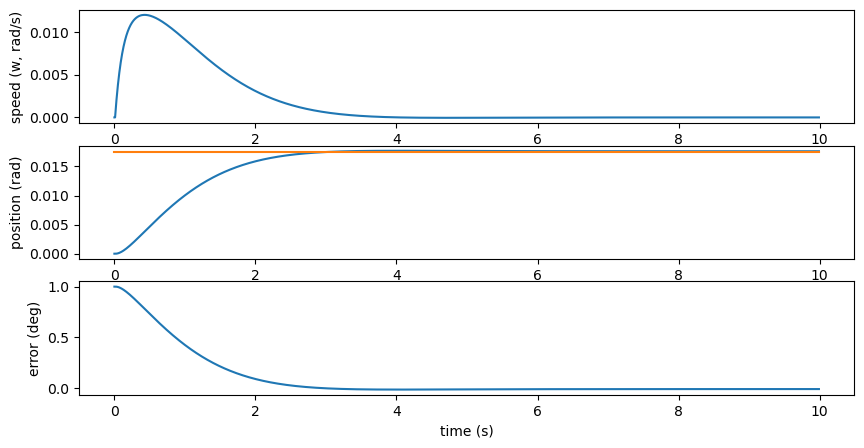

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10,5))

axs[0].plot(time_vector, velocity)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('speed (w, rad/s)')


axs[1].plot(time_vector, position)
axs[1].plot(time_vector, ref_position*np.ones(position.shape))
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('position (rad)');

axs[2].plot(time_vector, np.degrees(error))
axs[2].set_xlabel('time (s)')
axs[2].set_ylabel('error (deg)');

And now we can define it as a class.

To be honest, this class will do more than simply controlling the motor, but will do for now.

In [ ]:
#| export
class MotorController():
    def __init__(self, Kp, Kd, Ki, motor):        
        self.motor = motor
        self.Kp = Kp
        self.Kd = Kd
        self.Ki = Ki
        
        self.y_history = np.array([[0],[0]]) # initialise to 0. This is only here to have the correct size. Alternative: y = np.empty((2,1)) 
        self.error_history = np.array([[0]])
        self.elapsed_time = np.array([[0]])
        self.motor_torque = np.array([[0]])
        
        self._error_old = 0
        self._error_I  = 0
        

    def run(self, dt, ref_position_rad, y):               
#            y = self.motor.measure()
            position, velocity = y[0], y[1]        
            # apply controller
            error = ref_position_rad - position
            error_dot = (error - self._error_old)/dt
            self._error_I   += error*dt
            self._error_old = error
            # controller
            u = self.Kp*error + self.Kd*error_dot + self.Ki*self._error_I


            self.motor.step(dt, u)

            # save the last measurements     
            self.y_history = np.append(self.y_history, y, axis=1)  
            self.error_history = np.append(self.error_history, [error], axis=1)
            self.elapsed_time = np.append(self.elapsed_time, [[self.elapsed_time[0][-1]+dt]], axis=1)
            self.motor_torque = np.append(self.motor_torque, [[self.motor.get_motor_torque()]], axis=1)
    
    def get_results(self):
        # when we return remove the first item which was there only to have the correct size
        y_history = np.delete(self.y_history, 0, axis=1)
        error_history = np.delete(self.error_history, 0, axis=1)
        elapsed_time = np.delete(self.elapsed_time, 1, axis=1)
        motor_torque = np.delete(self.motor_torque, 0, axis=1)
        
        position = y_history[0,:]
        velocity = y_history[1,:]
        error = error_history[0,:]
        torque = motor_torque[0,:] 
        
        return position, velocity, error, torque

### Putting everything together

In [ ]:
p_params = PendulumParameters()
p_params.b = 0.2

m_params = DCMotorParams()

In [ ]:
pendulum = Pendulum(theta_0=np.radians(0), theta_dot_0=0, params=p_params)
motor = DCMotor(x0=np.array([[0], [0], [0]]), params=m_params)
motor_controller = MotorController(Kp=1000, Kd=500, Ki=1000, motor=motor)

# connect the motor to the pendulum
motor.connect_to(pendulum)

t0, tf, dt = 0, 20, 0.01
time_vector = np.arange(t0, tf, dt)

ref_position_rad=np.radians(5)
angle = []
for t in time_vector:       
    motor_controller.run(dt, 
                         ref_position_rad=ref_position_rad,
                         y = np.array([[np.radians(pendulum.sense_theta_deg())], [pendulum.speed()]]))
    T = motor_controller.motor.get_motor_torque()
    pendulum.step(dt, u=T)
    angle.append(pendulum.sense_theta_deg())


position, velocity, error, torque = motor_controller.get_results()

print('Reference position: {:.4f} rad/{:.1f} deg'.format(ref_position_rad, np.degrees(ref_position_rad)))
print('Pendulum position (tf): {:.4f} rad/{:.1f} deg'.format(np.radians(angle[-1]), angle[-1]))

Reference position: 0.0873 rad/5.0 deg
Pendulum position (tf): 0.0873 rad/5.0 deg


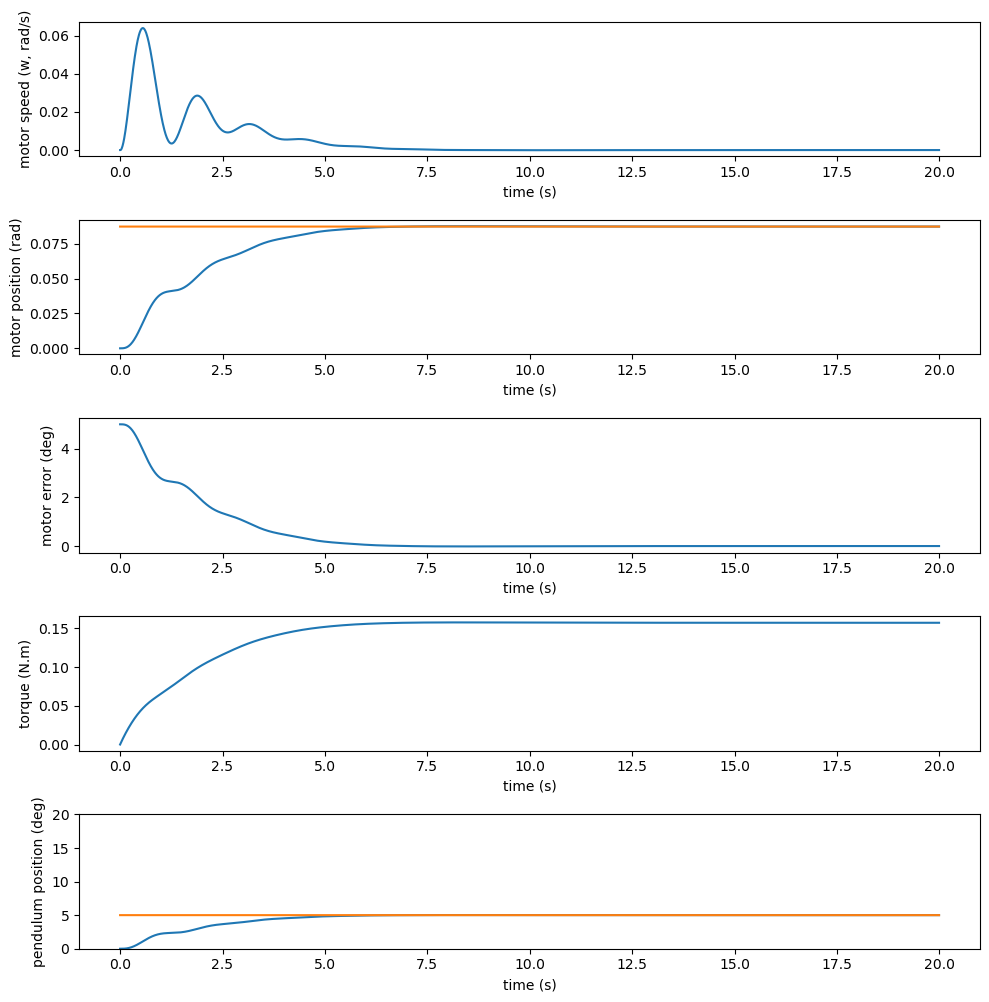

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10,10))

axs[0].plot(time_vector, velocity)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('motor speed (w, rad/s)')

axs[1].plot(time_vector, position)
axs[1].plot(time_vector, ref_position_rad*np.ones(position.shape))
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('motor position (rad)');

axs[2].plot(time_vector, np.degrees(error))
axs[2].set_xlabel('time (s)')
axs[2].set_ylabel('motor error (deg)');

axs[3].plot(time_vector, torque)
axs[3].set_xlabel('time (s)')
axs[3].set_ylabel('torque (N.m)');

axs[4].plot(time_vector, angle)
axs[4].plot(time_vector, np.degrees(ref_position_rad)*np.ones(position.shape))
axs[4].set_xlabel('time (s)')
axs[4].set_ylabel('pendulum position (deg)');
axs[4].set_ylim(0, 20)

plt.tight_layout()

In [ ]:
#| export
class AnimateControlledPendulum():
    """See also: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/"""
    def __init__(self, pendulum, motor, controller, t0, tf, dt):
        self._pendulum = pendulum
        self._motor = motor
        self._controller = controller
        
        # connect the motor to the pendulum
        motor.connect_to(pendulum)
        
        self._t0, self._tf, self._dt = t0, tf, dt
        self._data = defaultdict(list)
        
        self._fig = plt.figure()
        self._ax = self._fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                 xlim=(-.5, .5), ylim=(-.5, 0))
        self._ax.grid()
        self._line, = self._ax.plot([], [], 'o-', lw=2)   
        
        self._title = self._ax.text(0.5, 1.05, "", #bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                    transform=self._ax.transAxes, ha="center")
        
    def animate_init(self):
        """Initialize animation.
           Plot the background of each frame. """
        self._line.set_data([], [])        
        return self._line,
    
    def simulate(self, angle_ref, controller_flag=True):        
        for t in np.arange(start=self._t0, stop=self._tf, step=self._dt):            
            self._controller.run(self._dt, 
                             ref_position_rad=np.radians(angle_ref),
                             y = np.array([[np.radians(self._pendulum.sense_theta_deg())], [self._pendulum.speed()]]))
            self._pendulum.step(self._dt, u=self._controller.motor.get_motor_torque() if controller_flag else 0)
            self._data['angles'].append(self._pendulum.sense_theta_deg())
            self._data['time'].append(t)                        
    
    def animate(self, i):           
        """Animation function. 
           This is called sequentially to perform animation step"""                
        rod_end_1, rod_end_2 = self._pendulum.rod_position_at(self._data['angles'][i])
        self._line.set_data([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]])
        self._title.set_text(u"t = {:.1f}s".format(self._data['time'][i]))        
        return self._line, self._title
    
    def animate_and_simulate(self, i):   
        """Animation function. 
           This is called sequentially to perform animation step"""        
        self._pendulum.step(self._dt, u=0)     
        rod_end_1, rod_end_2 = self._pendulum.rod_position()
        self._line.set_data([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]])
        return line, time_text
    
    def start_animation(self):
        # choose the interval based on dt and the time to animate one step
        t_start = systime()
        self.animate(0)
        t_end = systime()
        interval = 1000 * self._dt - (t_end - t_start)
        n_frames = int((self._tf-self._t0)/self._dt)
        
        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(self._fig, self.animate, init_func=self.animate_init,
                                       frames=n_frames, interval=interval, blit=True,
                                       repeat_delay=10000, repeat=True);
        plt.close()
        return anim

In [ ]:
#%%capture
p_params = PendulumParameters()
p_params.b = 0.2
m_params = DCMotorParams()
pendulum = Pendulum(theta_0=np.radians(20), theta_dot_0=0, params=p_params)
motor = DCMotor(x0=np.array([[0], [0], [0]]), params=m_params)
controller = MotorController(Kp=1000, Kd=500, Ki=1000, motor=motor)



t0, tf, dt = 0, 10, 1./30 # time
ap = AnimateControlledPendulum(pendulum, motor, controller, t0, tf, dt)
ap.simulate(angle_ref=10, controller_flag=True);
ap.start_animation()